In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

device = torch.device("mps") # Using hardware acceleration on Mac M2!!

/Users/hridaybaghar/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset

In [2]:
# Writing a dataloader to load image data from ../data/ folder

class DASImageDataset(Dataset):
    def __init__(self, root_dir, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_file =(os.path.join(self.root_dir, self.files[index]))
        img = Image.open(img_file)
        
        if self.transform:
            img = self.transform(img)
        
        return img, self.files[index]

In [3]:
# Applying custom convolution kernel to the image

from torch.functional import F

class DiagonalEdge(object):
    def __init__(self):
        self.weight_left = torch.tensor([[-1, -1, 2], 
                                         [-1, 2, -1],
                                         [2, -1, -1]], dtype=torch.float32)
        
        self.weight_right = torch.flip(self.weight_left, [0])

    
    def __call__(self, img):
        img = F.conv2d(img.unsqueeze(0), self.weight_left.unsqueeze(0).unsqueeze(0), padding=1)
        img += F.conv2d(img, self.weight_right.unsqueeze(0).unsqueeze(0), padding=1)
        img = torch.sigmoid(img)
        img = (img > 0.53)*1.0
        return img.squeeze(0)
    
class ScalePixels(object):
    def __call__(self, img):
        img = (img - img.min())/(img.max() - img.min())
        return img
    

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.GaussianBlur(3, sigma=0.5),
    transforms.ToTensor(),
    DiagonalEdge(),
])

images = DASImageDataset(root_dir='../data/south_ch_10000to47499_fs100_bpf14to35Hz/', transform=transform)

train_len = int(0.8 * len(images))
test_len = len(images) - train_len

train_dataset, test_dataset = random_split(images, [train_len, test_len])

train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=32, sampler=RandomSampler(test_dataset))


In [5]:
def view_batch(batch):
    grid = make_grid(batch, nrow=8, padding=5)
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()

def view_image(img):
    img = img.squeeze()
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='binary_r')
    plt.show()

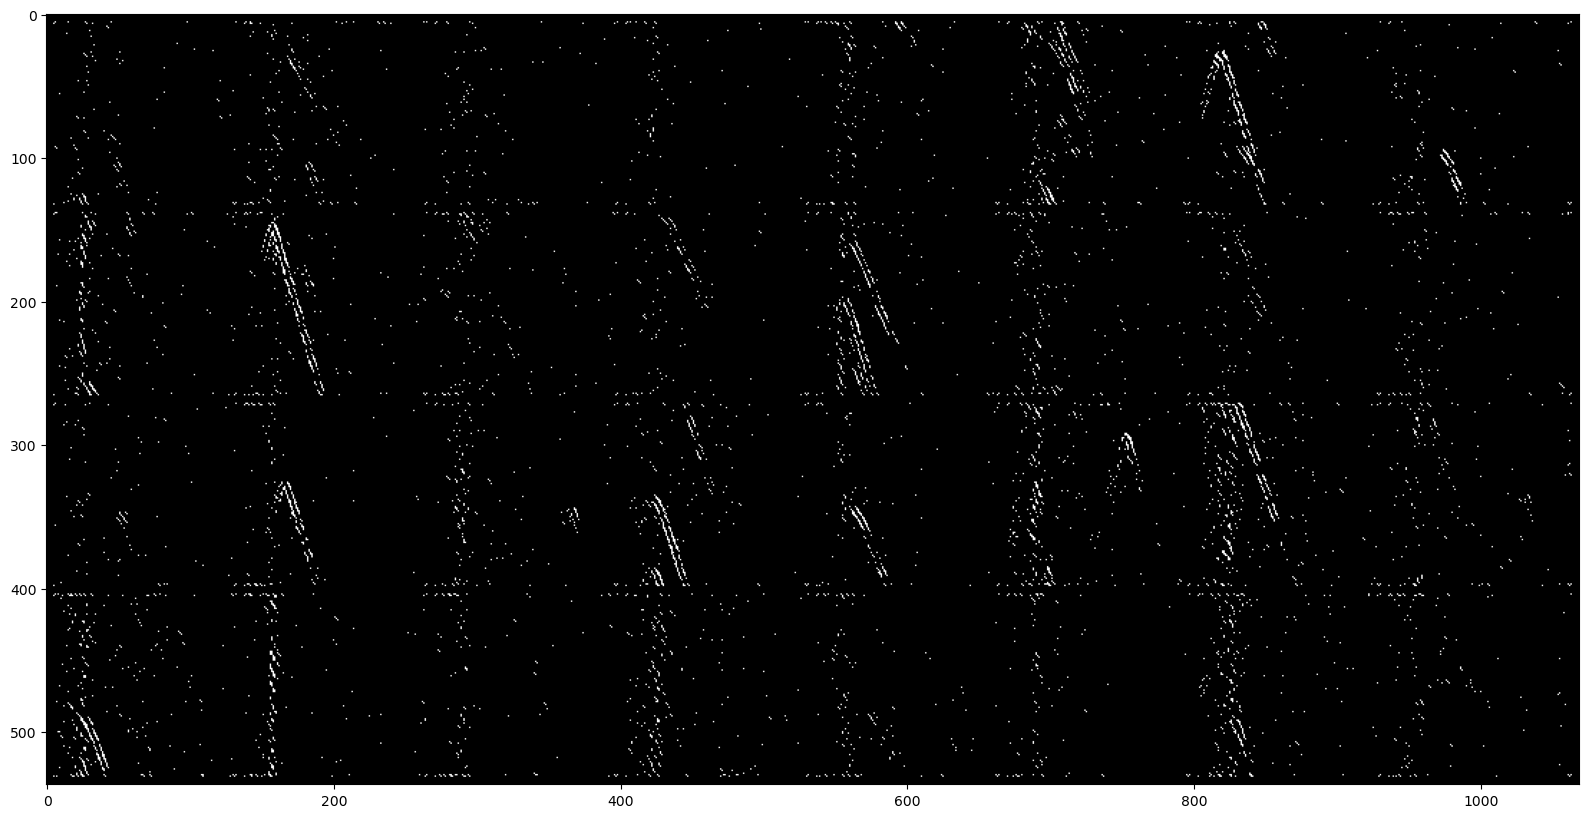

('2021-11-02T20:23:14.834000000.png', '2021-11-03T13:16:29.834000000.png', '2021-11-03T06:38:14.834000000.png', '2021-11-02T05:27:14.834000000.png', '2021-11-02T16:40:29.834000000.png', '2021-11-03T18:55:59.834000000.png', '2021-11-02T19:44:14.834000000.png', '2021-11-02T23:53:14.834000000.png', '2021-11-03T21:48:59.834000000.png', '2021-11-02T19:08:44.834000000.png', '2021-11-03T08:36:29.834000000.png', '2021-11-02T17:04:59.834000000.png', '2021-11-03T16:53:29.834000000.png', '2021-11-03T09:38:59.834000000.png', '2021-11-02T09:17:14.834000000.png', '2021-11-02T12:41:14.834000000.png', '2021-11-03T02:53:59.834000000.png', '2021-11-02T06:00:29.834000000.png', '2021-11-04T03:19:44.834000000.png', '2021-11-02T18:45:29.834000000.png', '2021-11-02T16:31:44.834000000.png', '2021-11-04T00:32:14.834000000.png', '2021-11-03T22:44:29.834000000.png', '2021-11-04T02:10:59.834000000.png', '2021-11-03T22:35:44.834000000.png', '2021-11-02T00:46:29.834000000.png', '2021-11-02T03:11:29.834000000.png', 

In [6]:
for batch, _ in train_dataloader:
    view_batch(batch)
    print(_)
    break

Building model - we have rewritten the code to work with 128x128 images

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        # self.encoder_cnn = nn.Sequential(
        #     nn.Conv2d(1, 8, 16, stride=2, padding=7), # (256 - 16 + 2*7)/2 + 1 = 128
        #     nn.ReLU(True),
        #     nn.Conv2d(8, 16, 16, stride=2, padding=7), # (128 - 16 + 2*7)/2 + 1 = 64
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(True),
        #     nn.Conv2d(16, 32, 16, stride=2, padding=7), # 
        #     nn.ReLU(True),
        #     nn.Conv2d(32, 64, 16, stride=2, padding=7), # (32 - 16 + 2*7)/2 + 1 = 16
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(True),
        #     nn.Conv2d(64, 128, 16, stride=2, padding=7), # (16 - 14 + 2*1)/2 + 1 = 8
        #     nn.ReLU(True)
        # )

        # Define for 128x128 images
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 8, stride=2, padding=3), # (128 - 8 + 2*3)/2 + 1 = 64
            nn.ReLU(True),
            nn.Conv2d(8, 16, 8, stride=2, padding=3), # (64 - 8 + 2*3)/2 + 1 = 32
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 8, stride=2, padding=3), # (32 - 8 + 2*3)/2 + 1 = 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 8, stride=2, padding=3), # (16 - 8 + 2*3)/2 + 1 = 8
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        # self.encoder_lin = nn.Sequential(
        #     nn.Linear(8 * 8 * 128, fc2_input_dim),
        #     nn.ReLU(True),
        #     nn.Linear(fc2_input_dim, encoded_space_dim)
        # )

        self.encoder_lin = nn.Sequential(
            nn.Linear(8 * 8 * 64, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        # self.decoder_lin = nn.Sequential(
        #     nn.Linear(encoded_space_dim, fc2_input_dim),
        #     nn.ReLU(True),
        #     nn.Linear(fc2_input_dim, 8 * 8 * 128),
        #     nn.ReLU(True)
        # )

        # self.unflatten = nn.Unflatten(dim=1, 
        # unflattened_size=(128, 8, 8))

        # self.decoder_conv = nn.Sequential(
        #     nn.ConvTranspose2d(128, 64, 16, stride=2, padding=7), #
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(64, 32, 16, stride=2, padding=7), # (16 - 1)*2 - 2*1 + 4 = 32
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(32, 16, 16, stride=2, padding=7), # (32 - 1)*2 - 2*1 + 4 = 64
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(16, 8, 16, stride=2, padding=7), # (64 - 1)*2 - 2*1 + 4 = 128
        #     nn.BatchNorm2d(8),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(8, 1, 16, stride=2, padding=7) # (128 - 1)*2 - 2*1 + 4 = 256
        # )

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 8 * 8 * 64),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(64, 8, 8))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=3), # (8 - 1)*2 - 2*1 + 4 = 16
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 8, stride=2, padding=3), # (16 - 1)*2 - 2*1 + 4 = 32
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 8, stride=2, padding=3), # (32 - 1)*2 - 2*1 + 4 = 64
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 8, stride=2, padding=3) # (64 - 1)*2 - 2*1 + 4 = 128
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [8]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, verbose=True):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the file names (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if verbose:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data



In [9]:
def plot_ae_outputs(encoder,decoder,dataset,n=10):
    plt.figure(figsize=(16,4.5))
    # targets = test_dataset.targets.numpy()
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    t_idx = np.random.randint(0,len(dataset),n)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

In [9]:
from tqdm.auto import trange

loss_fn = nn.MSELoss()
lr = 5e-3
encoded_space_dim = 32
fc2_input_dim = 512

encoder = Encoder(encoded_space_dim,fc2_input_dim).to(device)
decoder = Decoder(encoded_space_dim,fc2_input_dim).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

num_epochs = 100

diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in trange(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_dataloader,loss_fn,optimizer,verbose=False)
   val_loss = test_epoch(encoder,decoder,device,test_dataloader,loss_fn)
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

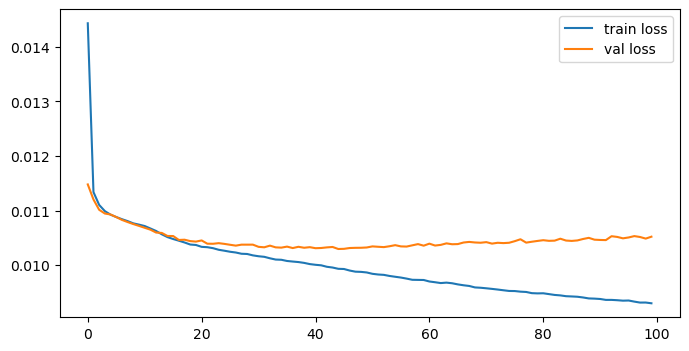

In [11]:
plt.figure(figsize=(8,4))
plt.plot(diz_loss['train_loss'],label='train loss')
plt.plot(diz_loss['val_loss'],label='val loss')
plt.legend()

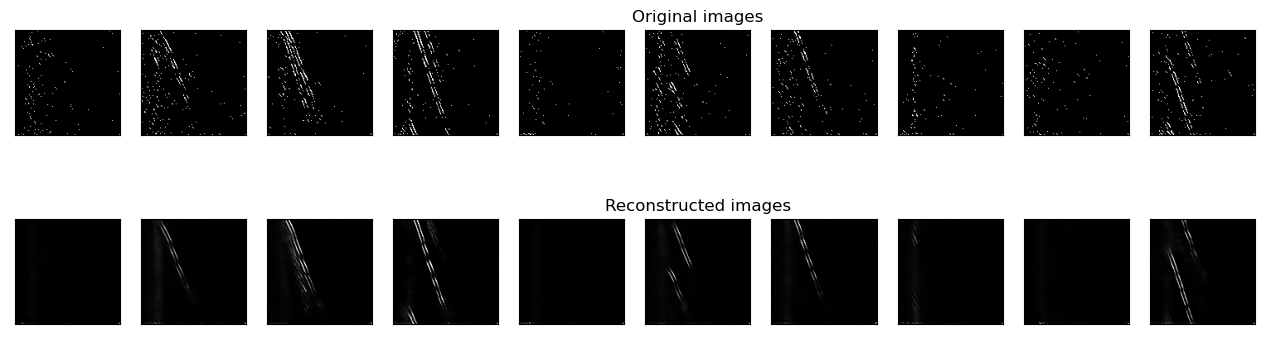

In [190]:
plot_ae_outputs(encoder,decoder,train_dataset,n=10)

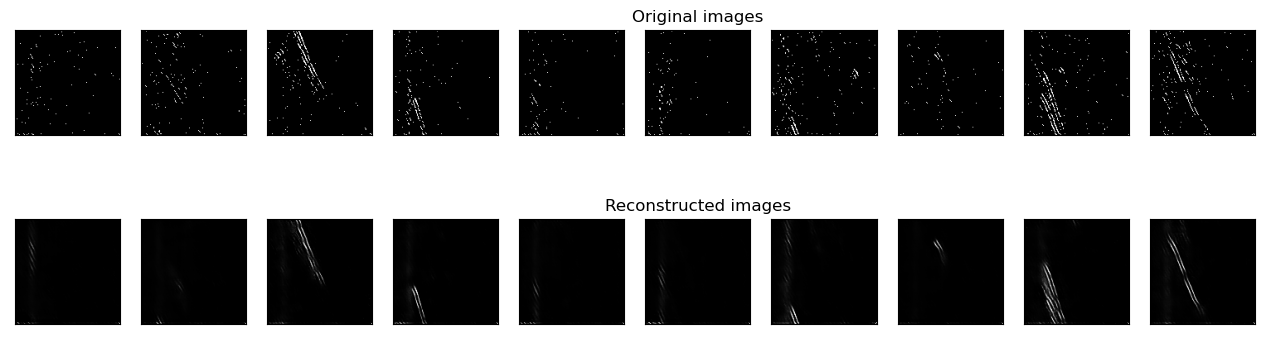

In [191]:
plot_ae_outputs(encoder,decoder,test_dataset,n=10)

When we enhance the diagonal lines, the model is actually able to pick out the signals. However, this is not very good on weaker smaller finwhale calls, because the preprocessing method itself is not very effective. Investing in improving training data quality is indeed the best use of time for us.

In [193]:
# Export the model
torch.save(encoder.state_dict(), 'model/encoder.pth')
torch.save(decoder.state_dict(), 'model/decoder.pth')

In [10]:
# Load encoder from pth file
encoder = Encoder(encoded_space_dim,fc2_input_dim).to(device)
encoder.load_state_dict(torch.load('model/encoder.pth'))

<All keys matched successfully>

In [11]:
# Apply the encoder to the whole training dataset and save the results to csv along with filenames
encoder.eval()
with torch.no_grad():
    encoded_data = {}
    for image_batch, file_names in tqdm(train_dataloader):
        image_batch = image_batch.to(device)
        encoded_data_batch = encoder(image_batch)
        for i in range(len(file_names)):
            encoded_data[file_names[i].split('.')[0]] = encoded_data_batch[i].cpu().numpy()
df = pd.DataFrame.from_dict(encoded_data, orient='index')
df.to_csv('model/encoded_data.csv')


100%|██████████| 327/327 [00:11<00:00, 28.22it/s]


In [178]:
[(i,f) for i,(_,f) in enumerate(images) if f.startswith('2021-11-02T15:32:44')]

[(6036, '2021-11-02T15:32:44.834000000.png')]

In [166]:
def view_result(img):
    result = decoder(encoder(img.unsqueeze(0).to(device)))
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    plt.subplot(1,2,2)
    plt.imshow(result.cpu().squeeze().detach().numpy(), cmap='gist_gray')
    plt.show()

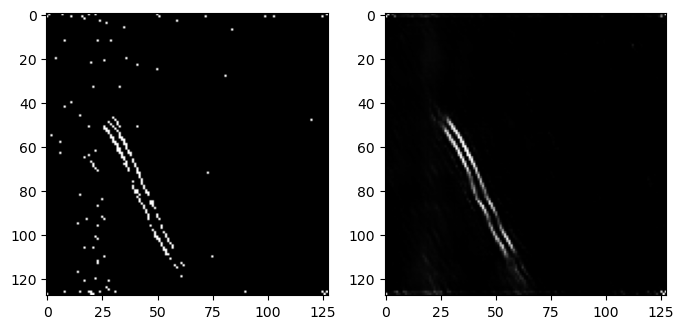

In [176]:
view_result(images[220][0])

In [170]:
def view_encoded(img):
    result = encoder(img.unsqueeze(0).to(device))
    plt.figure(figsize=(8,4))
    plt.subplot(2,1,1)
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    plt.subplot(2,1,2)
    plt.imshow(result.cpu().squeeze().detach().numpy()[np.newaxis,:], cmap='gist_gray')
    plt.show()

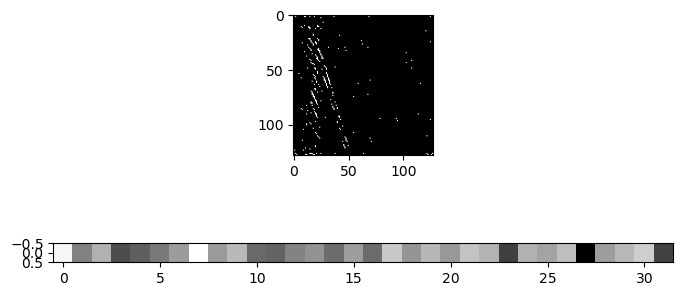

In [173]:
view_encoded(images[6709][0])

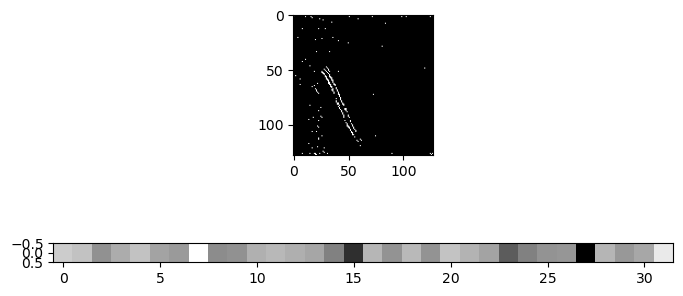

In [177]:
view_encoded(images[220][0])

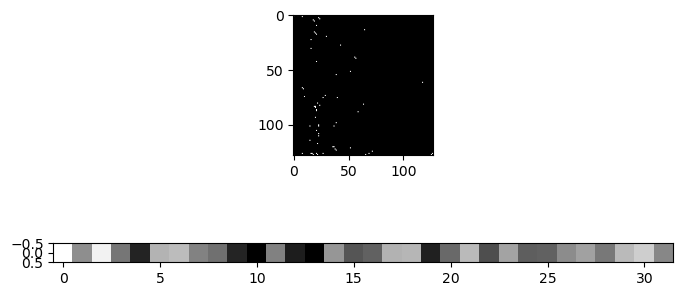

In [179]:
view_encoded(images[6036][0])